In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


SpaceNet on Jimura et al "mixed gambles" dataset.
==================================================

We will replicate some of the findings in [Analyses of regional-average activation and multivoxel pattern information tell
complementary stories](https://pdfs.semanticscholar.org/c682/667bf230dd8efab25e844dae0fb28a3947e4.pdf), which used a gambling task where the potential gain on the gambles was varied parametrically.

We will attempt to predict the "gain" (a number between 1-8) given the $\beta$ map derived from individual trials with that gain on a per-subject basis. As a result, we're using regression models, as opposed to classification models, given that the task is to predict a
continuous (rather than categorical) variable, the gain of the gamble.

We will use both a traditional regularized regression model applied to the maps (`Ridge`), as well as a more neuroscientifically inspired regularized model called [SpaceNet](https://www.ncbi.nlm.nih.gov/pubmed/23298747).

Load the data for the Jimura mixed-gamble experiment
------------------------------------------------------

In [2]:
import numpy as np
from nilearn.datasets import fetch_mixed_gambles
from nilearn.input_data import NiftiMasker
from nilearn.image import load_img, index_img
data = fetch_mixed_gambles(n_subjects=16)

zmap_filenames = data.zmaps
behavioral_target = data.gain
mask_filename = data.mask_img


Dataset created in /Users/suesong/nilearn_data/jimura_poldrack_2012_zmaps



/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


In [3]:
data.keys()

dict_keys(['zmaps', 'subject_id', 'gain', 'mask_img'])

In [147]:
data["zmaps"][3].get_data().flatten().shape

(65280,)

In [148]:
data["subject_id"][:5]

array([0, 0, 0, 0, 0])

In [6]:
data["gain"]

array([1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6,
       7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4,
       5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2,
       3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8,
       1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6,
       7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4,
       5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2,
       3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8,
       1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6,
       7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4,
       5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2,
       3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8,
       1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6,
       7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5,

In [174]:
data["mask_img"].get_data().flatten().shape

(65280,)

## Ridge Regularized Regression

* Mask the individual z-maps with the provided epi mask to generate appropriate samples * features matrix.
* Select the top 50% of most active voxels for regression features. 
* Apply ridge regression on voxels, use leave-one-subject-out cross-validation.

In [177]:
masker = NiftiMasker(mask_img=mask_filename, standardize=False,mask_strategy="epi")

In [178]:
zmaps_masked = masker.fit_transform(zmap_filenames)
zmaps_masked.shape

In [123]:
X,y,chunks = zmaps_masked,behavioral_target,data["subject_id"]

In [124]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score,LeaveOneGroupOut
from sklearn.feature_selection import SelectPercentile, f_classif

In [77]:
cv = LeaveOneGroupOut()
feature_selection = SelectPercentile(f_classif, percentile=50)

In [81]:
from sklearn.pipeline import Pipeline
fs_ridge = Pipeline([('anova', feature_selection), ('ridge', Ridge())])

In [101]:
ridge_scores = cross_val_score(fs_ridge,
                               X,y.astype(float),
                               scoring="r2",
                               cv=cv,
                               groups=data["subject_id"],
                               n_jobs=-1)

Here's our cross-subject $r^2$:

In [106]:
ridge_scores[ridge_scores<0]=0 #set negative r^2 to 0 as at worst, we simply predict the mean
np.mean(ridge_scores)

0.06222799098612329

It is incredibly low, but non-zero. Let's visualize the fitted coefficients:

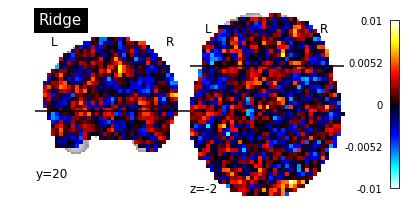

In [201]:
from nilearn.plotting import plot_img, plot_stat_map

ridge_decoder = Ridge().fit(X,y.astype(float))
ridge_coef_img = masker.inverse_transform(ridge_decoder.coef_)

plot_stat_map(ridge_coef_img, title="Ridge", display_mode="yz",
              cut_coords=[20, -2]);

In [202]:
from niwidgets import NiftiWidget

ridge_widg = NiftiWidget(ridge_coef_img)
ridge_widg.nifti_plotter(plotting_func=plot_stat_map, threshold=(-.01, .01, 0.001),
                   display_mode=['ortho','xz'])

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='threshold', max=0.01, min=-0.01, step=0.001), Dropdo…

Here's the $r^2$ when you use a `Dummy Regressor`, which simply predicts the mean of the training data

In [107]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor()
fs_dummy = Pipeline([('anova', feature_selection), ('dummy', dummy)])
dummy_scores = cross_val_score(fs_dummy,
                               X,
                               y.astype(float),
                               scoring="r2",
                               cv=cv,
                               groups=data["subject_id"],
                               n_jobs=-1)


In [108]:
np.mean(dummy_scores)

0.0

As expected, it is exactly 0 (A regressor that simply predicts the mean of the response will always have an $r^2=0$).

Fit SpaceNet with Graph-Net penalty
----------
Now, let's do the same exact thing with a different, spatially informed regularized regression model, called `Space-Net`.

In [37]:
from nilearn.decoding import SpaceNetRegressor
from sklearn.model_selection import cross_val_score,LeaveOneGroupOut

In [109]:
decoder = SpaceNetRegressor(mask=mask_filename, penalty="graph-net",
                            eps=1e-1,  # prefer large alphas
                            memory="nilearn_cache",
                            n_jobs=-1,
                            cv=16)#cross-validate with leave one subject out

decoder.fit(zmap_filenames, behavioral_target)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


/usr/local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:291: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "
/usr/local/lib/python3.7/site-packages/nilearn/decoding/space_net.py:835: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  1.9min remaining:  1.1min


Time Elapsed: 131.696 seconds, 2 minutes.


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


SpaceNetRegressor(alphas=None, cv=16, debias=False, eps=0.1,
         fit_intercept=True, high_pass=None, l1_ratios=0.5, low_pass=None,
         mask=<nibabel.nifti1.Nifti1Image object at 0x10e7da278>,
         max_iter=1000, memory=Memory(cachedir='nilearn_cache/joblib'),
         memory_level=1, n_alphas=10, n_jobs=-1, penalty='graph-net',
         screening_percentile=20.0, standardize=True, t_r=None,
         target_affine=None, target_shape=None, tol=0.0001, verbose=1)

In [110]:
graph_net_cv_scores = decoder.cv_scores_.flatten()
graph_net_cv_scores[graph_net_cv_scores <= 0] = 0 #set negative r^2 to 0 as before

In [111]:
np.mean(graph_net_cv_scores)

0.12023511863754566

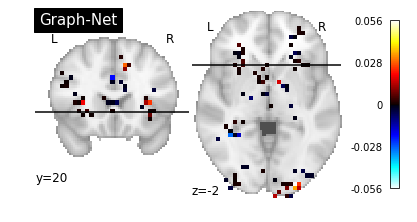

In [203]:
# Visualize Graph-Net weights
# ------------------------
plot_stat_map(decoder.coef_img_, title="Graph-Net", display_mode="yz",
              cut_coords=[20, -2]);

In [205]:
graphnet_widg = NiftiWidget(decoder.coef_img_)
graphnet_widg.nifti_plotter(plotting_func=plot_stat_map, threshold=(-.06, .06, 0.001),
                   display_mode=['ortho','xz'])

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='threshold', max=0.06, min=-0.06, step=0.001), Dropdo…

Fit Space-Net with TV-L1 penalty
--------------



In [214]:
decoder_tvl1 = SpaceNetRegressor(mask=mask_filename, penalty="tv-l1",
                            eps=1e-1,  # prefer large alphas
                            memory="nilearn_cache",cv=16,memory_level=5,verbose=0)
decoder_tvl1.fit(zmap_filenames, behavioral_target)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


/usr/local/lib/python3.7/site-packages/nilearn/decoding/space_net.py:835: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 48, ..., 767]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 0), debias=False, verbose=1, screening_percentile=17.21112329324533)


.......

_____________________________________________________path_scores - 38.3s, 0.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 1), debias=False, verbose=1, screening_percentile=17.21112329324533)


......

_____________________________________________________path_scores - 63.9s, 1.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 2), debias=False, verb

......

_____________________________________________________path_scores - 26.0s, 0.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 3), debias=False, verb

......

_____________________________________________________path_scores - 53.8s, 0.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 4), debias=False, verb

......

_____________________________________________________path_scores - 70.6s, 1.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 5), debias=False, verb

..........

_____________________________________________________path_scores - 29.7s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 6), debias=False, verb

.....

_____________________________________________________path_scores - 36.7s, 0.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378, 379, 380, 381, 382, 383]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 7), debias=False, verb

......

_____________________________________________________path_scores - 44.5s, 0.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
       397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
       410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 8), debias=False, verb

..........

_____________________________________________________path_scores - 43.2s, 0.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
       445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
       471, 472, 473, 474, 475, 476, 477, 478, 479]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 9), debias=False, verb

.......

_____________________________________________________path_scores - 31.6s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 10), debias=False, ver

.........

_____________________________________________________path_scores - 31.3s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553,
       554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566,
       567, 568, 569, 570, 571, 572, 573, 574, 575]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 11), debias=False, ver

......

_____________________________________________________path_scores - 31.2s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601,
       602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614,
       615, 616, 617, 618, 619, 620, 621, 622, 623]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 12), debias=False, ver

....

_____________________________________________________path_scores - 64.9s, 1.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
       637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649,
       650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
       663, 664, 665, 666, 667, 668, 669, 670, 671]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 13), debias=False, ver

......

_____________________________________________________path_scores - 31.2s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 767]), array([672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684,
       685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697,
       698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
       711, 712, 713, 714, 715, 716, 717, 718, 719]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 14), debias=False, ver

.....

_____________________________________________________path_scores - 39.6s, 0.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x10e82b730>, loss='mse'), array([[-8.078031e-09, ...,  1.090077e+00],
       ...,
       [-9.155192e-01, ..., -2.586967e+00]]), 
array([1, ..., 8]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 719]), array([720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745,
       746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767]), 
{'max_iter': 1000, 'tol': 0.0001}, n_alphas=10, eps=0.1, is_classif=False, key=(0, 15), debias=False, ver

......

_____________________________________________________path_scores - 32.5s, 0.5min
Time Elapsed: 678.243 seconds, 11 minutes.


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 11.2min finished


SpaceNetRegressor(alphas=None, cv=16, debias=False, eps=0.1,
         fit_intercept=True, high_pass=None, l1_ratios=0.5, low_pass=None,
         mask=<nibabel.nifti1.Nifti1Image object at 0x10e7da278>,
         max_iter=1000, memory=Memory(cachedir='nilearn_cache/joblib'),
         memory_level=5, n_alphas=10, n_jobs=1, penalty='tv-l1',
         screening_percentile=20.0, standardize=True, t_r=None,
         target_affine=None, target_shape=None, tol=0.0001, verbose=1)

In [215]:
tv_l1_cv_scores = decoder_tvl1.cv_scores_.flatten()
tv_l1_cv_scores[tv_l1_cv_scores <= 0] = 0 #set negative r^2 to 0 as before

In [216]:
tv_l1_cv_scores.mean()

0.06988106828835929

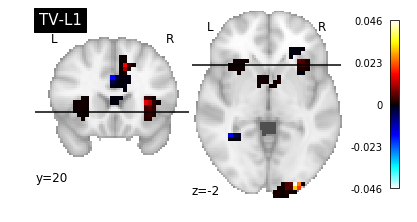

In [218]:
plot_stat_map(decoder_tvl1.coef_img_, title="TV-L1", display_mode="yz",
              cut_coords=[20, -2]);

In [219]:
tvl1_widg = NiftiWidget(decoder_tvl1.coef_img_)
tvl1_widg.nifti_plotter(plotting_func=plot_stat_map, threshold=(-.05, .05, 0.001),
                   display_mode=['ortho','xz'])

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='threshold', max=0.05, min=-0.05, step=0.001), Dropdo…